# MATH5271 Environmental Data Science and Statistics



## Week 3: Time Series I - Time domain



### Welcome to Week 3 of MATH5271. This session is the first of two on time series analysis. By the end of this session you should understand:

- Utility of both time domain and frequency domain methods;
- How to model discrete data using Multi-state Markov Chain models;
- How to model continuous data using auto-regression models

## Terminology

What do the following terms mean?

- Steady
- Stationairy
- Cyclical
- Ergodic*

## In terms of time series terminology, how would you describe the following processes:

- El Nino Southern Oscilation measured over a decade;
- Rain drops falling on your roof during a constant shower;
- A large Hymalayan Glacier measured annually over 10 years;
- Sea ice coverage in the Arctic Ocean.

## Time Series Models

Unlike in Statistical Forecasting where we had either a proxy (e.g. nearby temperature) or a process based model (e.g. Numerical Weather Prediction) with which to make a model. In time series analysis we aim to understand, and potentially predict, the behaviour of a single time series. There are two approaches we will discuss:

- Time domain analysis;
- Frequency domain or Harmonic analysis.




## Time Domain

Future State = f(previous state, earlier state, even earlier state...)

## Frequency Domain

Future State = Stage in cycle 1 + Stage in cycle 2 + ... 

## Setup and Load Data

Before we get started we need to ensure we have the appropriate 'libraries' are installed. The .csv files we upload will be uploaded into a 'pandas' data frame. We will use the 'numpy' (numerical python) package to do some basic maths with the data and Matplotlib's 'pyplot' package to make some pretty graphs. 

In [1]:
# import libraries
import pandas as pd

# Numerics
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# plot figures in Colaboratory notebook
%matplotlib inline

# Define the URL where the data set is stored
TableA1_url = 'https://raw.githubusercontent.com/janzika/MATH5271/main/Wilks_TableA1.csv' 

# Import the data set as a Pandas Dataframe using the 'read_csv' function
df1 = pd.read_csv(TableA1_url)

# Subset just the Ithaca and Canandaigua data
idf = df1[df1['Location'].isin(['Ithaca'])]
cdf = df1[df1['Location'].isin(['Canandaigua'])]

# Define a new column with logical 0 for no rain and 1 for rain
idf.insert(4,"Rain",[1 if x > 0 else 0 for x in idf.Precip_inch])

#Copy the data frame from the 2nd of January and add a 'rained yesterday' columnx
idf2 = idf[1:].copy()
idf2.insert(5,"Rain_Yesterday",idf.Rain[0:-1].values)

## Time domain

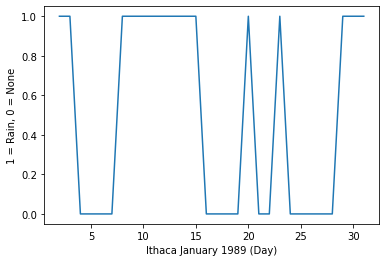

In [17]:
plt.plot(idf2.Date,idf2.Rain)
plt.xlabel('Ithaca January 1989 (Day)');
plt.ylabel('1 = Rain, 0 = None'); 

### How could we model this?

## Markov Chain



In [ ]:
# Find the number of transitions between each state
n00 = idf2[(idf2.Rain_Yesterday==0) & (idf2.Rain==0)].shape[0]
n01 = idf2[(idf2.Rain_Yesterday==0) & (idf2.Rain==1)].shape[0]
n10 = idf2[(idf2.Rain_Yesterday==1) & (idf2.Rain==0)].shape[0]
n11 = idf2[(idf2.Rain_Yesterday==1) & (idf2.Rain==1)].shape[0]

n0d = n00+n01
n1d = n10+n11
nd0 = n00+n10
nd1 = n01+n11

n = n0d+n1d

p00 = n00/n0d
p01 = n01/n0d
p10 = n10/n1d
p11 = n11/n1d

e00 = n0d*nd0/n
e01 = n0d*nd1/n
e10 = n1d*nd0/n
e11 = n1d*nd1/n

Xi2 = (n00-e00)**2/e00 + (n10-e10)**2/e10 + \
(n01-e01)**2/e01 + (n11-e11)**2/e11


In [ ]:
# Find the number of transitions between each state
def Xisq(yesterday,today):
    n00 = yesterday[(yesterday==0) & (today==0)].shape[0]
    n01 = yesterday[(yesterday==0) & (today==1)].shape[0]
    n10 = yesterday[(yesterday==1) & (today==0)].shape[0]
    n11 = yesterday[(yesterday==1) & (today==1)].shape[0]
    
    n0d = n00+n01
    n1d = n10+n11
    nd0 = n00+n10
    nd1 = n01+n11
    
    n = n0d+n1d
    
    p00 = n00/n0d
    p01 = n01/n0d
    p10 = n10/n1d
    p11 = n11/n1d
    
    e00 = n0d*nd0/n
    e01 = n0d*nd1/n
    e10 = n1d*nd0/n
    e11 = n1d*nd1/n

    Xi2 = (n00-e00)**2/e00 + (n10-e10)**2/e10 + \
    (n01-e01)**2/e01 + (n11-e11)**2/e11
    return Xi2

In [ ]:
X2 = Xisq(idf2.Rain_Yesterday,idf2.Rain)
X2

In [ ]:
after_norain = idf2.Rain[(idf2.Rain_Yesterday==0)].values
after_rain = idf2.Rain[(idf2.Rain_Yesterday==1)].values

N = 30
markov = np.zeros([N,1])
indep = np.zeros([N,1])
day = np.arange(0,N)

markov[0]=random.choice(idf2.Rain.values)
indep[0]=random.choice(idf2.Rain.values)
for i in day[:-1]:
    indep[i+1] = random.choice(idf2.Rain.values)
    if markov[i] == 0:
        markov[i+1] = np.random.choice(after_norain)
    else:
        markov[i+1] = np.random.choice(after_rain)
        
plt.plot(day,markov,label='Markov Chain Model')
plt.plot(day,indep,label='Serially independent model')
plt.xlabel('Day');plt.ylabel('1=Rain, 0=None'); plt.legend()#markov[:-1]

Xisq_markov = Xisq(markov[:-1],markov[1:])
Xisq_indep = Xisq(indep[:-1],indep[1:])

print(Xisq_markov,Xisq_indep)

In [ ]:
# Calculate b and a
x0 = cdf.MinTemp_Far.values[:-1]
x1 = cdf.MinTemp_Far.values[1:]
n = x0.shape[0]
phi = (n*np.sum(x0*x1)-np.sum(x0)*np.sum(x1))\
/(n*np.sum(x0**2)-((np.sum(x0))**2))

mu = x1.mean()

#a = x0.mean() - phi*x0.mean()
# Determine the least squares guess at 'y' (the Canandaigua temperature)
x1_lr = phi*(x0-mu)+mu;

plt.scatter(x0,x1)
plt.plot(x0,x1_lr)

z = b/np.sqrt(1/(n+1))

sx = cdf.MinTemp_Far.std()

mu = cdf.MinTemp_Far.values.mean()

sig_e2 = (1-b**2)*cdf.MinTemp_Far.var()

print(b,z,sx)

sig_e = np.sqrt(sig_e2)

In [ ]:
se2  = (1/(n-2))*sum((x1-x1_lr)**2)
se2

In [ ]:
N = 30;day = np.arange(0,N)
AR1 = np.zeros([N,1])
RND = np.zeros([N,1])

AR1[0]=random.choice(cdf.MinTemp_Far.values)
RND[0]=random.choice(cdf.MinTemp_Far.values)
for i in day[:-1]:
    RND[i+1] = np.random.normal(mu,sx)
    AR1[i+1] = phi*(AR1[i]-mu)+np.random.normal(mu,sig_e)
        
plt.plot(day,AR1,label='Auto Regressive Model')
plt.plot(day,RND,label='Serially independent model')
plt.xlabel('Day');plt.ylabel('Minimum Temp. ($^o$F)'); 
plt.legend()

In [ ]:
x = cdf.MinTemp_Far.values
n = x.shape[0]
M=7
r = np.ones([M+1,1])

x[-(n-5):]
for k in np.arange(1,M+1):
    xmns = x[:n-k].mean()
    xpls = x[-(n-k):].mean()
    r[k] = np.sum((x[:n-k]-xmns)*(x[-(n-k):]-xpls))/\
    (np.sqrt(np.sum((x[:n-k]-xmns)**2))*np.sqrt(np.sum((x[-(n-k):]-xpls)**2))) 
    #phi = np.linalg.solve()

plt.plot(r)
r

In [ ]:
K=6
A = np.ones([K,K])
for i in np.arange(0,K):
    A[i:,i] = r[:K-i,0] #np.arange(0,K-i)#
    A[np.arange(i,-1,-1),i]=r[0:i+1,0]#np.arange(0,i+1)#
    
phi = np.linalg.solve(A.transpose(),r[1:K+1])

xhat = np.zeros([n,])
for i in np.arange(K,n):
    #xhat[i] = np.sum(phi.transpose()*(x[np.arange(i-1,i-K-1,-1)]-x[K:].mean()))+x[K:].mean()
    xhat[i] = np.sum(phi.transpose()*(x[np.arange(i-1,i-K-1,-1)]-x.mean()))+x.mean()
    
#plt.scatter(xhat[K:n],x[K:n])

vare = (xhat[K:n]-x[K:n]).var()*(n/(n-1))
#rho = np.zeros([K+1,])
#rho[0]=1
#for i in np.arange(1,K+1):
#    rho[i]=np.sum(phi[:i].transpose()*rho[np.arange(i-1,0-1,-1)])
#sige = (1-np.sum(rho[1:]*phi.transpose()))*x.var()*(n/(n-1))
vare


In [ ]:
phi[:i].transpose()

In [ ]:
rho[np.arange(i-1,0-1,-1)]

In [ ]:
rho = np.ones([K,])
for i in np.arange(1,K):
    rho[i]=np.sum(phi[:i].transpose()*rho[np.arange(i,0,-1)])
rho

In [ ]:
np.arange(i-1,i-K-1,-1)


## Forecasting

When forecasting, we aim to make a predictions, $\hat{y}$, of the value of a specific 'predictand' $y_i$, as a function of a set of predictors ${\bf x}_i$ such that

$$y_i = \hat{y}({\bf x}_i)+e_i.$$

Above, $e_i$ is the error between the prediction and predictand and $\hat{y}$ is designed so that $e_i$ is as small as possible. Although $e_i$ is (of course) unknown a priori, its statistical properties are of as much interest as the central prediction.

## Statistical Forecasting vs What?

Statistical forecasting involves developing the function $\hat{y}$ and determining the nature of $e$ based on some prior knowledge of $y_i$ and $\bf{x}_i$. (These are often called ‘training’ data.)


What are alternative approaches and when/how are the different approaches applicable?

Examples: 
- Arrival time of a Tsunami;
- Number of Orange Bellied Parrots arriving for summer in Tasmania;
- Possibility of a La Niña in 2023.


![NINOForecast.png](https://raw.githubusercontent.com/janzika/MATH5271/main/Lecture%202/NINOForecast.png)
Infographic adapted by Elisabeth Gawthrop from figure by Tony Barnston.

### Linear Regression
linear regression is a simple example of a forecasting system. For a predictor $x_i$ we have

$$ y_i = a + b x_i +  e_i.$$

In this case we can simply calculate the slope $b$ and the intercept $a$ using

$$ b = \frac{\sum_{i=1}^n \left[ (x_i - \overline{x})((y_i - \overline{y})\right]}{\sum_{i=1}^n (x_i - \overline{x})^2} \,\, \text{and}\,\, a = \overline{y} - b \overline{x}.$$


This is garaunteed to minimise the mean of the square of the residuals 

$$ s_e^2 = \frac{1}{n-2}\sum_{i=1}^n e_i^2.$$

Let's recreate this relationship based on Wilk's Ithaca and Canandaigua minimum temperatures.

In [ ]:
# Subset just the Ithaca and Canandaigua data
idf = df1[df1['Location'].isin(['Ithaca'])]
x = idf.MinTemp_Far.values
cdf = df1[df1['Location'].isin(['Canandaigua'])]
y = cdf.MinTemp_Far.values
n = x.shape[0]

In [ ]:
# Calculate b and a
b = (n*np.sum(x*y)-np.sum(x)*np.sum(y))\
/(n*np.sum(x**2)-((np.sum(x))**2))
a = y.mean() - b*x.mean()
# Determine the least squares guess at 'y' (the Canandaigua temperature)
y_lr = a + b*x;

In [ ]:
# Make the plot using matplotlib (plt)
plt.scatter(x,y,label='Raw data');
plt.plot(x,y_lr,'r',label='Linear Fit')
plt.xlabel('Ithaca min. temp. ($x$, $^{\circ}$F)')
plt.ylabel('Canandaigua min. temp. ($y$, $^{\circ}$F)')
plt.legend()

This reveals the kind of relationship we were after. Now let's take a closer look at the uncertainty. 

The mean square of the resudials or MSE is often used as an estimate of the uncertainty but in fact we need to use the prediction variance which is

$$ s^2_{\hat{y}} = s_e^2\left[ 1 + \frac{1}{n} + \frac{(x_0 - \overline{x})^2}{\sum_{i=1}^n(x_i - \overline{x})^2}\right].$$


We can also determine the uncertainty in the fit line itself via the 'variance of the conditional mean'

$$ s^2_{\hat{y}|x_0} = s_e^2\left[\frac{1}{n} + \frac{(x_0 - \overline{x})^2}{\sum_{i=1}^n(x_i - \overline{x})^2}\right].$$

In [ ]:
# Determine the mean square error, the prediciton variance and variance of the 
# conditional mean
se2  = (1/(n-2))*sum((y-y_lr)**2)
sy2 = se2*(1+ (1/n) + (x-x.mean())**2/(sum((x-x.mean())**2)))
syx02 = se2*((1/n) + (x-x.mean())**2/(sum((x-x.mean())**2)))
# Plot
plt.scatter(x,y)
plt.plot(x,y_lr,'r')
plt.plot(x,y_lr+1.96*np.sqrt(sy2),'k',x,y_lr-1.96*np.sqrt(sy2),'k')
plt.plot(x,y_lr+1.96*np.sqrt(syx02),'g',x,y_lr-1.96*np.sqrt(syx02),'g')
plt.xlabel('Ithaca min. temp. ($x$, $^{\circ}$F)')
plt.ylabel('Canandaigua min. temp. ($y$, $^{\circ}$F)')

## Multiple Linear Regression
Multiple linear regression allows for multiple ($K$) predictors 

$$ \hat{y}(x_1,x_2,x_K) = b_0 + b_1 x_1 +  b_2 x_2 + ... + b_K x_K$$

Furthermore, $x_i$ can be a ‘derived’ predictor variable such as $x^i$. This special case is a polynomial fit.

$$ \hat{y}(x) = b_0 + b_1 x +  b_2 x^2 + ... + b_K x^K$$

The model itself is ‘non-linear’ but the regression is linear since we are just looking for the coefficients $b_i$.

## How to do multiple linear regression
Python packages such as numpy have various inbuilt functions such as 'polyfit' for fitting polynomials and similar special cases. If we want to use mupltiple predictors then it is more general to set the problem up in matrix form such that

$$ \text{X} \bf{b} = \bf{y} $$

where $\text{A}$ is a K by n matrix of predictors, $\bf{b}$ are the K unknown regression parameters and $\bf{y}$ are the $n$ observations $y_i$. If n>K the inversion $\bf{b} = \text{X}^{-1} \bf{y} $ is solved using least squares.

In [ ]:
#Solve our simple linear fit using numpy's 'polyfit':
[b_poly,a_poly] =  np.polyfit(x,y,1)

#Solve using linear algebra:
#Make a 2 by n matrix with 1s as the first column and the predictor x as the second
X = np.array([1+0*x,x]).transpose()
# Now we have A b = y and we can use numpy's 'linalg.lstsq' function
bmat  = np.linalg.lstsq(X,y,rcond=None)

#Compare direct, polyfit and matrix approaches
print(a,b)
print(a_poly,b_poly)
print(bmat[0][0],bmat[0][1])

## Analysis of variance and 'goodness' of fit

![ANOVAtable.png](https://raw.githubusercontent.com/janzika/MATH5271/main/Lecture%202/ANOVAtable.png)

$$ R^2 = \frac{SSR}{SST} = 1 - \frac{SSE}{SST}$$


## Nonlinear Regression
We can also do operations on the left hand side such as for ’Poisson Regression’  

$$ \ln(\hat{y}) = b_0 + b_1 x_1 +  b_2 x_2 + ... + b_K x_K$$

or 'Logistic Regression'

$$ \ln(\hat{y}/(1-\hat{y})) = b_0 + b_1 x_1 +  b_2 x_2 + ... + b_K x_K.$$

Since we know the LHS and RHS can we simply solve this using the methods above?


## What do these functions look like?



## Where might each be useful?

## Other Considerations?
![scattererror.png](https://raw.githubusercontent.com/janzika/MATH5271/main/Lecture%202/scattererror.png)

## Predictor Selection

Why not use all available data to make a fit? What should be done instead?

![predictorselection.png](https://raw.githubusercontent.com/janzika/MATH5271/main/Lecture%202/predictorselection.png)

## Predictor Selection

Why not use all available data to make a fit? What should be done instead?

<div>
<img src="https://raw.githubusercontent.com/janzika/MATH5271/main/Lecture%202/predictorselection.png" width="400"/>
</div>


![predictselect2.png](https://raw.githubusercontent.com/janzika/MATH5271/main/Lecture%202/predictselect2.png)

## Process Based Model Forecasts

![NWP.png](https://raw.githubusercontent.com/janzika/MATH5271/main/Lecture%202/NWP.png)

https://www.youtube.com/watch?v=QrGrbiHBmWg&t=121s

Process Based Model Forecasts

![NWP2.png](https://raw.githubusercontent.com/janzika/MATH5271/main/Lecture%202/NWP2.png)

## Perfect Prog and MOS

Classic Forecasting: $\hat{y}_t = f_C(\bf{x}_0)$

Prefect Prog: 

$\hat{y}_0 = f_{PP}(\bf{x}_0)$ (development) and

$\hat{y}_t = f_{PP}(\bf{x}_t)$ (implementation).

Model Output Statistics (MOS): 

$\hat{y}_t = f_{MOS}(\bf{x}_t)$

## Perfect Prog and MOS

<div>
<img src="https://raw.githubusercontent.com/janzika/MATH5271/main/Lecture%202/ProgMOS.png" width="500"/>
</div>

## Perfect Prog and MOS

![ProgMOS.png](https://raw.githubusercontent.com/janzika/MATH5271/main/Lecture%202/ProgMOS.png)

## Ensemble forecasts and data assimilation

![ensforecast.png](https://raw.githubusercontent.com/janzika/MATH5271/main/Lecture%202/ensforecast.png)

A schematic representation of the data assimilation process from [Apte A. (2015) An Introduction to Data Assimilation](doi.org/10.1007/978-81-322-2547-8_4)


## Summary

We have discussed:

*   How linear regression works and how to do it in python;
* Some aspects of nonlinear regression and overfitting;
* How statistical forecasts can be combined with process based forecasts.
